In [ ]:
!pip install fastjet
!pip install vector
!pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.1/865.1 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.7/637.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.3/362.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00


In [ ]:
import uproot
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/MyDrive/ML_HEP/Data_files/fcc_ee_ZH_H_ssbar_ecm_240GeV.root"
tree = uproot.open(data_file)["events"]

Mounted at /content/drive


In [ ]:
tree.num_entries # total number of events

100000

In [ ]:
tree.keys()

['Muon#0',
 'Muon#0/Muon#0.index',
 'Muon#0/Muon#0.collectionID',
 'ReconstructedParticles',
 'ReconstructedParticles/ReconstructedParticles.type',
 'ReconstructedParticles/ReconstructedParticles.energy',
 'ReconstructedParticles/ReconstructedParticles.momentum.x',
 'ReconstructedParticles/ReconstructedParticles.momentum.y',
 'ReconstructedParticles/ReconstructedParticles.momentum.z',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.x',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.y',
 'ReconstructedParticles/ReconstructedParticles.referencePoint.z',
 'ReconstructedParticles/ReconstructedParticles.charge',
 'ReconstructedParticles/ReconstructedParticles.mass',
 'ReconstructedParticles/ReconstructedParticles.goodnessOfPID',
 'ReconstructedParticles/ReconstructedParticles.covMatrix[10]',
 'ReconstructedParticles/ReconstructedParticles.clusters_begin',
 'ReconstructedParticles/ReconstructedParticles.clusters_end',
 'ReconstructedParticles/ReconstructedParti

In [ ]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Muon#0               | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'Mu...
Muon#0/Muon#0.index  | int32_t[]                | AsJagged(AsDtype('>i4'))
Muon#0/Muon#0.col... | int32_t[]                | AsJagged(AsDtype('>i4'))
ReconstructedPart... | vector<edm4hep::Recon... | AsGroup(<TBranchElement 'Re...
ReconstructedPart... | int32_t[]                | AsJagged(AsDtype('>i4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
ReconstructedPart... | float[]                  | AsJagged(AsDtype('>f4'))
R

In [ ]:
pid = tree['Particle.PDG'].array() # Ids of particles
p_status = tree['Particle.generatorStatus'].array() # Generator status of particles. The generator status is 1 for stable particles.
m = tree['Particle.mass'].array() # Masses of particles
px = tree['Particle.momentum.x'].array() # X-momentum of particles
py = tree['Particle.momentum.y'].array() # Y-momentum of particles
pz = tree['Particle.momentum.z'].array() # Z-momentum of particles
p_begin = tree['Particle.parents_begin'].array() # Indices of first parent
p_end = tree['Particle.parents_end'].array() # Indices of last parent
p_ind = tree['Particle#0.index'].array() # Indices of parents

In [ ]:
# Function to calculate energy
def energy(m, px, py, pz):
    E = np.sqrt( m**2 + px**2 + py**2 + pz**2)
    return E

In [ ]:
e = energy(m, px, py, pz) # Energy of particles

In [ ]:
def get_parent_ids(i, particle_ids, parent_indices, parents_begin, parents_end) :
    """
    Find parent ID and it's index in the particle IDs list.

    Parameters:
        i (integer): Index of the stable particle.
        particle_ids (list): A list of IDs of particles.
        parent_indices (list): A list of parent indices of particles.
        parents_begin (list): A list of indices of the first parent of each particle.
        parents_end (list): A list of indices of the last parent of each particle.

    Returns:
        parent_id (integer): Parent ID of the stable particle.
        parent_indx (integer): Index of the parent particle.

    """
    pb = parents_begin[i]
    pe = parents_end[i]

    if pb == pe :
      return 0, 0
    else :
      for id in range(pb, pe) :
        parent_indx = parent_indices[id]
        parent_id = particle_ids[parent_indx]
      return parent_id, parent_indx

In [ ]:
def find_parent_and_daughter_ids(indices, particle_ids, all_particle_ids):
    """
    Find parent IDs and corresponding daughter IDs for each repeated index.

    Parameters:
        indices (list): A list of parent indices corresponding to stable particles.
        particle_ids (list): A list of IDs of stable particles.
        all_particle_ids (list): A list of all particle IDs.

    Returns:
        list: [[parent index, parent ID, list of daughter IDs],...,....].
    """
    if len(indices) != len(particle_ids):
        raise ValueError("Indices and particle_ids must have the same length.")
    if len(indices) > len(all_particle_ids):
        raise ValueError("Indices cannot reference more particles than all_particle_ids.")

    # Count occurrences of each index
    counts = Counter(indices)

    # Identify repeated indices
    repeated_indices = {index for index, count in counts.items() if count >= 2}

    # Collect parent and daughter IDs for repeated indices
    parent_daughters = []
    for index in repeated_indices:
        parent_id = all_particle_ids[index]  # Get the parent ID using the index
        daughters = [particle_ids[i] for i in range(len(indices)) if indices[i] == index]
        parent_daughters.append([index, parent_id, daughters])

    return parent_daughters

In [ ]:
def f(R) : # R is the radius parameter
  n_jets = [] # A list containing number of jets in each event
  dijet_m = [] # A list containing dijet invariant mass in each event
  dijet_pt = [] # A list containing dijet pt (transverse momentum) in each event
  dijet_eta = [] # A list containing dijet eta (pseudorapidity) in each event
  dijet_constituents = [] # A list containing total number of constituents of dijet in each event

  photon_count = [] # Total number of photons in the dijet
  muon_count = [] # Total number of muons in the dijet
  electron_count = [] # Total number of electrons in the dijet
  Ks_count = [] # Total number of Ks strange meson in the dijet
  lambda_count = [] # Total number of lambda strange baryon in the dijet
  lambdabar_count = [] # Total number of lambdabar strange baryon in the dijet

  photon_e = [] # Photon energy in the dijet
  muon_e = [] # Muon energy in the dijet
  electron_e = [] # Electron energy in the dijet
  Ks_e = [] # Ks energy in the dijet
  lambda_e = [] # Lambda energy in the dijet
  lambdabar_e = [] # Lambdabar energy in the dijet

  N = 100000 # number of events

  for n in range(N) : # Taking upto N number of events
    particles_list = [] # a list of particles in an event

    Leading_indx_0 = [] # A list of indices of constitents of the first leading jet
    Leading_indx_1 = [] # A list of indices of constitents of the second leading jet

    parent_indices_0 = [] # A list of indices of constitents of the first leading jet
    parent_indices_1 = [] # A list of indices of constitents of the second leading jet

    photon_counts_0 = 0 # Total number of photons in the first leading jet
    muon_counts_0 = 0 # Total number of muons in the first leading jet
    electron_counts_0 = 0 # Total number of electrons in the first leading jet
    Ks_counts_0 = 0 # Total number of Ks strange meson in the first leading jet
    lambda_counts_0 = 0 # Total number of lambda strange baryon in the first leading jet
    lambdabar_counts_0 = 0 # Total number of lambdabar strange baryon  in the first leading jet

    photon_e_0 = 0 # Photon energy in the first leading jet
    muon_e_0 = 0 # Muon energy in the first leading jet
    electron_e_0 = 0 # Electron energy in the first leading jet
    Ks_e_0 = 0 # Ks energy in the first leading jet
    lambda_e_0 = 0 # Lambda energy in the first leading jet
    lambdabar_e_0 = 0 # Lambdabar energy in the first leading jet

    photon_counts_1 = 0 # Total number of photons in the second leading jet
    muon_counts_1 = 0 # Total number of muons in the second leading jet
    electron_counts_1 = 0 # Total number of electrons in the second leading jet
    Ks_counts_1 = 0 # Total number of photons in the second leading jet
    lambda_counts_1 = 0 # Total number of photons in the second leading jet
    lambdabar_counts_1 = 0 # Total number of photons in the second leading jet

    photon_e_1 = 0
    muon_e_1 = 0
    electron_e_1 = 0
    Ks_e_1 = 0
    lambda_e_1 = 0
    lambdabar_e_1 = 0


    sts = p_status[n]
    p_x = px[n]
    p_y = py[n]
    p_z = pz[n]
    E = e[n]
    ids = pid[n]
    pinds = p_ind[n]
    pbegin = p_begin[n]
    pend = p_end[n]

    for i in range(len(p_x)) : # looping over the particles in an event
      part_p4 = PseudoJet(float(p_x[i]), float(p_y[i]), float(p_z[i]), float(E[i]))
      part_p4.set_user_index(i) # setting the index of the particle
      particles_list.append(part_p4)

    stable_p4 = []

    for i in range(len(particles_list)) :
      if sts[i] == 1 :
        stable_p4.append(particles_list[i])

    # Applying clustering of particles with anti-kt algorithm
    cluster = ClusterSequence(stable_p4, JetDefinition(antikt_algorithm, R))
    jet_set = sorted_by_pt(cluster.inclusive_jets()) # jets obtained from inclusive form of clustering algorithm, sorted by pT (decreasing pT)

    # Dijet kinematics
    dijet = jet_set[0] + jet_set[1]
    d_m = dijet.m() # invariant mass
    d_pt = dijet.pt() # transverse momentum
    d_eta = dijet.eta() # pseudo rapidity
    d_e = dijet.e() # energy

    Leading_constituents_0 = jet_set[0].constituents()

    for i in range(len(Leading_constituents_0)) :
      Leading_indx_0.append(Leading_constituents_0[i].user_index())

    for j in Leading_indx_0 :
      if ids[j] == 22 :
        photon_counts_0 += 1
        photon_e_0 += particles_list[j].e()
      if ids[j] == 13 :
        muon_counts_0 += 1
        muon_e_0 += particles_list[j].e()
      if ids[j] == 11 :
        electron_counts_0 += 1
        electron_e_0 += particles_list[j].e()

      parent_id_0, parent_indx_0 = get_parent_ids(j, ids, pinds, pbegin, pend)
      parent_indices_0.append(parent_indx_0)

    Leading_ids_0 = ids[Leading_indx_0]
    pd_0 = find_parent_and_daughter_ids(parent_indices_0, Leading_ids_0, ids)

    for k in range(len(pd_0)) :
      indx_0 = pd_0[k][0]
      id_0 = pd_0[k][1]
      if id_0 == 310 :
        Ks_counts_0 += 1
        Ks_e_0 += particles_list[indx_0].e()
      if id_0 == 3122 :
        lambda_counts_0 += 1
        lambda_e_0 += particles_list[indx_0].e()
      if id_0 == -3122 :
        lambdabar_counts_0 += 1
        lambdabar_e_0 += particles_list[indx_0].e()

    Leading_constituents_1 = jet_set[1].constituents()

    for i in range(len(Leading_constituents_1)) :
      Leading_indx_1.append(Leading_constituents_1[i].user_index())

    for j in Leading_indx_1 :
      if ids[j] == 22 :
        photon_counts_1 += 1
        photon_e_1 += particles_list[j].e()
      if ids[j] == 13 :
        muon_counts_1 += 1
        muon_e_1 += particles_list[j].e()
      if ids[j] == 11 :
        electron_counts_1 += 1
        electron_e_1 += particles_list[j].e()

      parent_id_1, parent_indx_1 = get_parent_ids(j, ids, pinds, pbegin, pend)
      parent_indices_1.append(parent_indx_1)

    Leading_ids_1 = ids[Leading_indx_1]
    pd_1 = find_parent_and_daughter_ids(parent_indices_1, Leading_ids_1, ids)

    for k in range(len(pd_1)) :
      indx_1 = pd_1[k][0]
      id_1 = pd_1[k][1]
      if id_1 == 310 :
        Ks_counts_1 += 1
        Ks_e_1 += particles_list[indx_1].e()
      if id_1 == 3122 :
        lambda_counts_1 += 1
        lambda_e_1 += particles_list[indx_1].e()
      if id_1 == -3122 :
        lambdabar_counts_1 += 1
        lambdabar_e_1 += particles_list[indx_1].e()

    photon_energy = photon_e_0 + photon_e_1
    muon_energy = muon_e_0 + muon_e_1
    electron_energy = electron_e_0 + electron_e_1
    Ks_energy = Ks_e_0 + Ks_e_1
    lambda_energy = lambda_e_0 + lambda_e_1
    lambdabar_energy = lambdabar_e_0 + lambdabar_e_1

    N_constituents = len(Leading_constituents_0) + len(Leading_constituents_1)

    photon_counts = photon_counts_0 + photon_counts_1
    muon_counts = muon_counts_0 + muon_counts_1
    electron_counts = electron_counts_0 + electron_counts_1
    Ks_counts = Ks_counts_0 + Ks_counts_1
    lambda_counts = lambda_counts_0 + lambda_counts_1
    lambdabar_counts = lambdabar_counts_0 + lambdabar_counts_1

    n_jets.append(len(jet_set))
    dijet_m.append(d_m)
    dijet_pt.append(d_pt)
    dijet_eta.append(d_eta)
    dijet_constituents.append(N_constituents)

    photon_e.append(photon_energy)
    muon_e.append(muon_energy)
    electron_e.append(electron_energy)
    Ks_e.append(Ks_energy)
    lambda_e.append(lambda_energy)
    lambdabar_e.append(lambdabar_energy)

    photon_count.append(photon_counts)
    muon_count.append(muon_counts)
    electron_count.append(electron_counts)
    Ks_count.append(Ks_counts)
    lambda_count.append(lambda_counts)
    lambdabar_count.append(lambdabar_counts)

  return n_jets, dijet_m, dijet_pt, dijet_eta, dijet_constituents, photon_count, muon_count, electron_count, Ks_count, lambda_count, lambdabar_count, photon_e, muon_e, electron_e, Ks_e, lambda_e, lambdabar_e

In [ ]:
R = f(0.8)

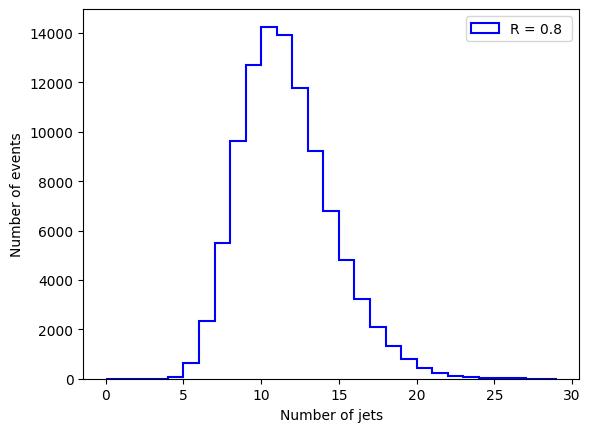

In [ ]:
n_jets = R[0]
plt.hist(n_jets, bins = np.arange(0, 30), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()

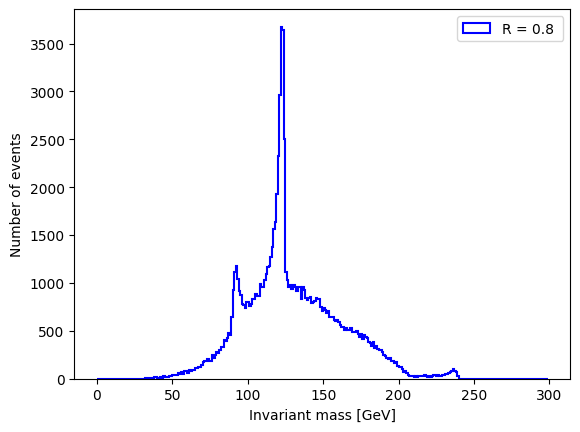

In [ ]:
dijet_m = R[1]
plt.hist(dijet_m, bins = np.arange(0, 300), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Invariant mass [GeV]")
plt.ylabel("Number of events")
plt.legend()
plt.show()

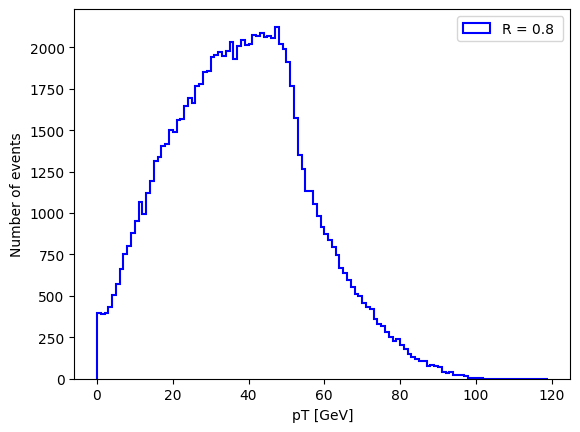

In [ ]:
dijet_pt = R[2]
plt.hist(dijet_pt, bins = np.arange(0, 120), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("pT [GeV]")
plt.ylabel("Number of events")
plt.legend()
plt.show()

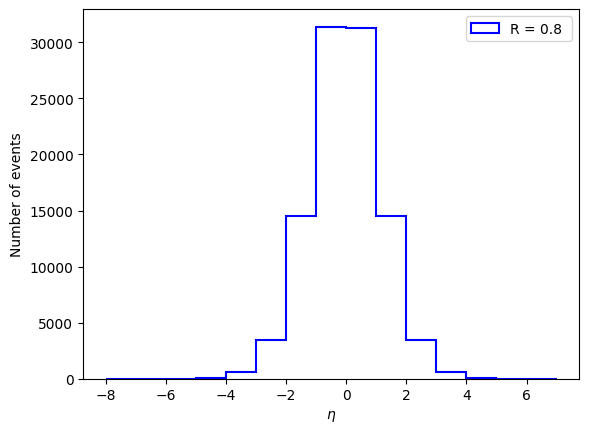

In [ ]:
dijet_eta = R[3]
plt.hist(dijet_eta, bins = np.arange(-8, 8), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$\eta$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

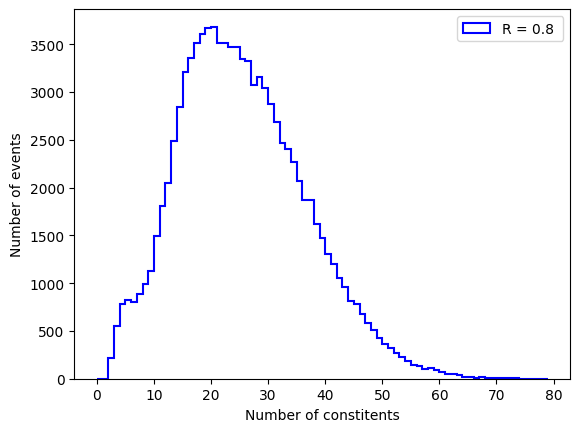

In [ ]:
dijet_constituents = R[4]
plt.hist(dijet_constituents, bins = np.arange(0, 80), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of constitents")
plt.ylabel("Number of events")
plt.legend()
plt.show()

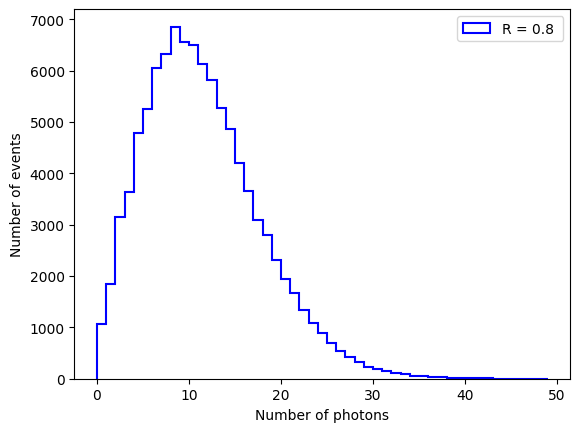

In [ ]:
n_photons = R[5]
plt.hist(n_photons, bins = np.arange(0, 50), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of photons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

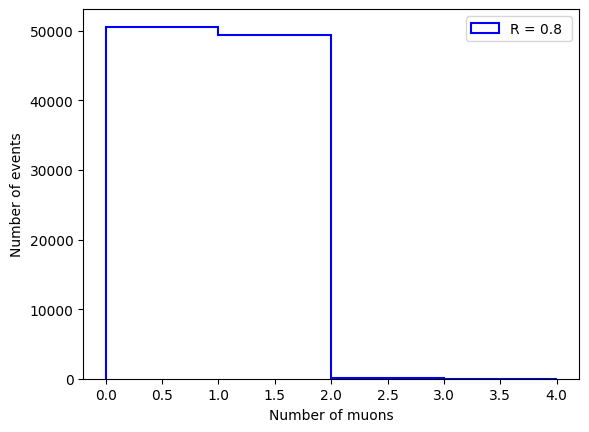

In [ ]:
n_muons = R[6]
plt.hist(n_muons, bins = np.arange(0, 5), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of muons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

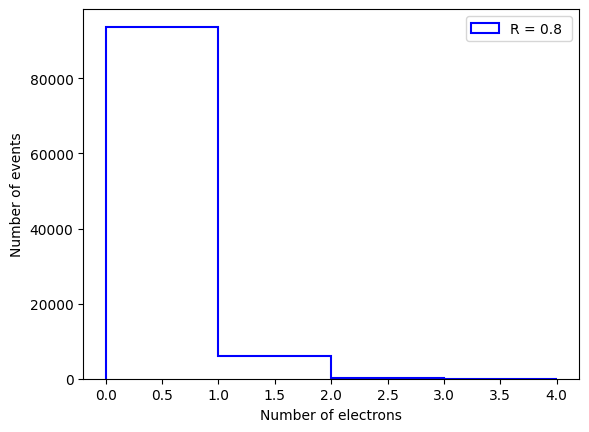

In [ ]:
n_electrons = R[7]
plt.hist(n_electrons, bins = np.arange(0, 5), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of electrons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

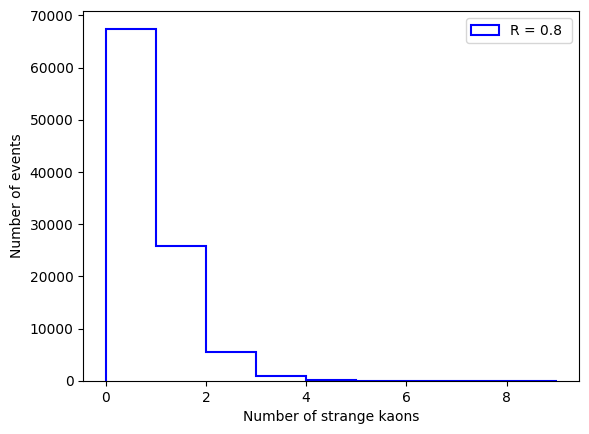

In [ ]:
n_ks = R[8]
plt.hist(n_ks, bins = np.arange(0, 10), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of strange kaons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

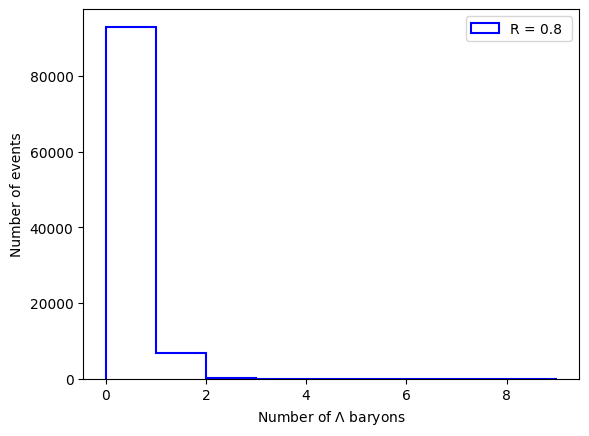

In [ ]:
n_lb = R[9]
plt.hist(n_lb, bins = np.arange(0, 10), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of $\Lambda$ baryons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

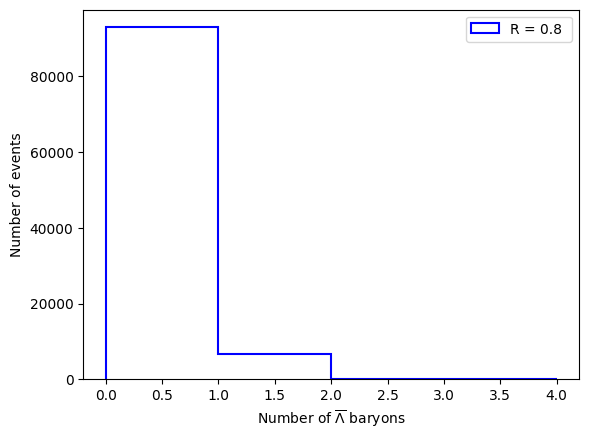

In [ ]:
n_alb = R[10]
plt.hist(n_alb, bins = np.arange(0, 5), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel(r"Number of $\overline {\Lambda}$ baryons")
plt.ylabel("Number of events")
plt.legend()
plt.show()

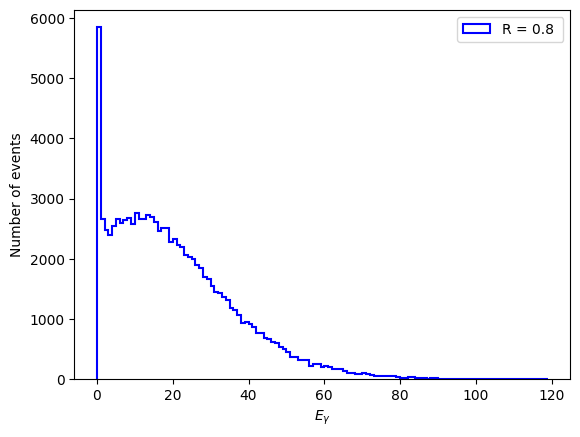

In [ ]:
photon_e = R[11]
plt.hist(photon_e, bins = np.arange(0, 120), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{\gamma}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

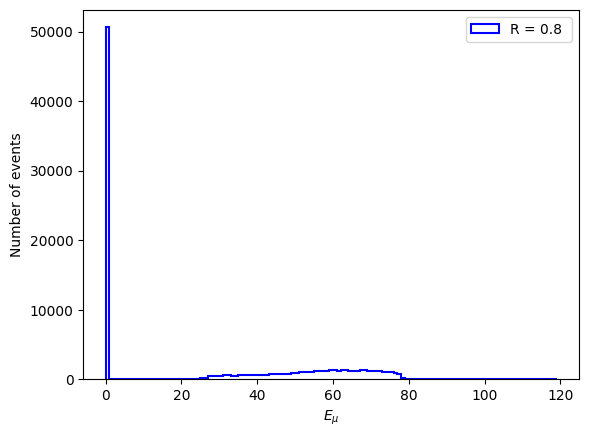

In [ ]:
muon_e = R[12]
plt.hist(muon_e, bins = np.arange(0, 120), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{\mu}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

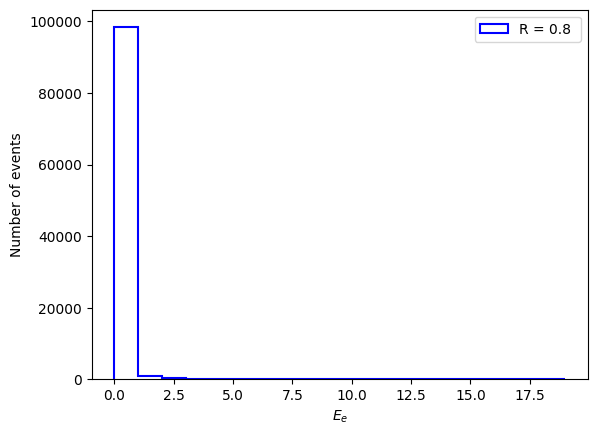

In [ ]:
electron_e = R[13]
plt.hist(electron_e, bins = np.arange(0, 20), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{e}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

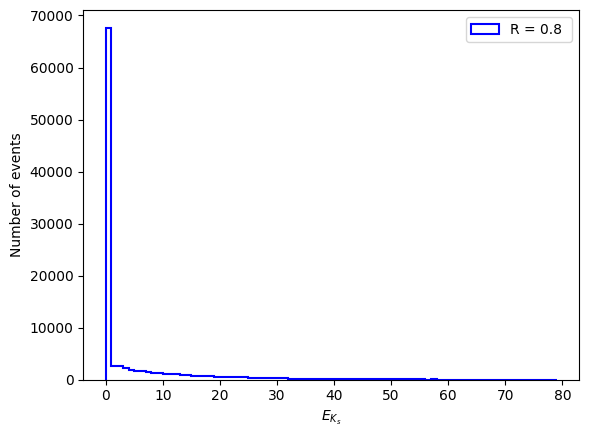

In [ ]:
Ks_e = R[14]
plt.hist(Ks_e, bins = np.arange(0, 80), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{K_{s}}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

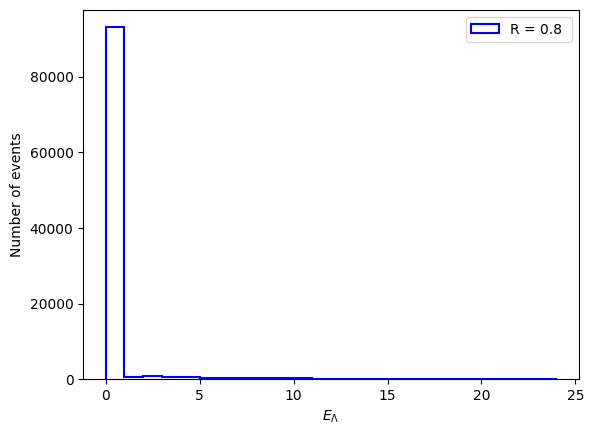

In [ ]:
lambda_e = R[15]
plt.hist(lambda_e, bins = np.arange(0, 25), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("$E_{\Lambda}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

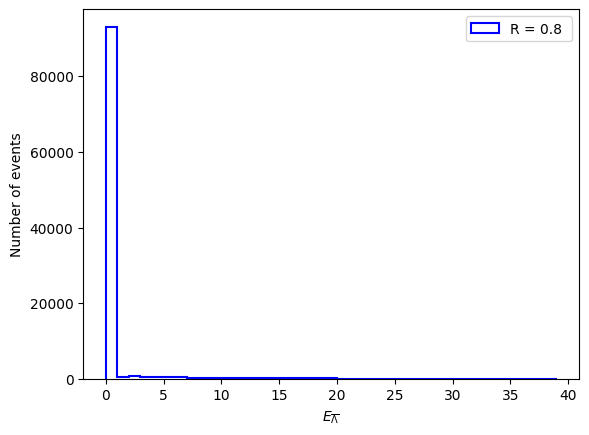

In [ ]:
lambdabar_e = R[16]
plt.hist(lambdabar_e, bins = np.arange(0, 40), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel(r"$E_{\overline{\Lambda}}$")
plt.ylabel("Number of events")
plt.legend()
plt.show()

In [ ]:
rows = 3
cols = 4
a = [[0 for _ in range(cols)] for _ in range(rows)]
a

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

In [ ]:
n_nodes = 10
n_node_ft = 12
a = [[0 for _ in range(n_node_ft)] for _ in range(n_nodes)]
a

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
a = [1, 2]
b = [3, 4]
c = a + b
d = [a, b]
d[1][0]

3

In [ ]:
def get_parent_ids(i, particle_ids, parent_indices, parents_begin, parents_end) :
    """
    Find parent ID and it's index in the particle IDs list.

    Parameters:
        i (integer): Index of the stable particle.
        particle_ids (list): A list of IDs of particles.
        parent_indices (list): A list of parent indices of particles.
        parents_begin (list): A list of indices of the first parent of each particle.
        parents_end (list): A list of indices of the last parent of each particle.

    Returns:
        parent_id (integer): Parent ID of the stable particle.
        parent_indx (integer): Index of the parent particle.

    """
    pb = parents_begin[i]
    pe = parents_end[i]

    if pb == pe :
      return 0
    else :
      for id in range(pb, pe) :
        parent_indx = parent_indices[id]
      return parent_indx

In [ ]:
def find_parent_and_daughter_ids(indices, particle_ids, all_particle_ids):
    """
    Find parent IDs and corresponding daughter IDs for each repeated index.

    Parameters:
        indices (list): A list of parent indices corresponding to stable particles.
        particle_ids (list): A list of IDs of stable particles.
        all_particle_ids (list): A list of all particle IDs.

    Returns:
        list: [[parent index, parent ID, list of daughter IDs],...,....].
    """
    # Count occurrences of each index
    counts = Counter(indices)

    # Identify repeated indices
    repeated_indices = {index for index, count in counts.items() if count >= 2}

    # Collect parent and daughter IDs for repeated indices
    parent_daughters = []
    for index in repeated_indices:
        parent_id = all_particle_ids[index]  # Get the parent ID using the index
        daughters = [particle_ids[i] for i in range(len(indices)) if indices[i] == index]
        parent_daughters.append([index, parent_id, daughters])

    return parent_daughters

In [ ]:
def f(R) : # R is the radius parameter
  n_jets = [] # A list containing number of jets in each event
  dijet_m = [] # A list containing dijet invariant mass in each event
  dijet_pt = [] # A list containing dijet pt (transverse momentum) in each event
  dijet_eta = [] # A list containing dijet eta (pseudorapidity) in each event
  dijet_constituents = [] # A list containing total number of constituents of dijet in each event

  photon_count = [] # Total number of photons in the dijet
  muon_count = [] # Total number of muons in the dijet
  electron_count = [] # Total number of electrons in the dijet
  Ks_count = [] # Total number of Ks strange meson in the dijet
  lambda_count = [] # Total number of lambda strange baryon in the dijet
  lambdabar_count = [] # Total number of lambdabar strange baryon in the dijet

  photon_e = [] # Photon energy in the dijet
  muon_e = [] # Muon energy in the dijet
  electron_e = [] # Electron energy in the dijet
  Ks_e = [] # Ks energy in the dijet
  lambda_e = [] # Lambda energy in the dijet
  lambdabar_e = [] # Lambdabar energy in the dijet

  N = 100000 # number of events

  for n in range(N) : # Taking upto N number of events
    particles_list = [] # a list of particles in an event

    constituent_indx = [] # A list of indices of constitents of the first leading jet

    parent_indices = [] # A list of indices of constitents of the first leading jet

    photon_counts = 0 # Total number of photons in the first leading jet
    muon_counts = 0 # Total number of muons in the first leading jet
    electron_counts = 0 # Total number of electrons in the first leading jet
    Ks_counts = 0 # Total number of Ks strange meson in the first leading jet
    lambda_counts = 0 # Total number of lambda strange baryon in the first leading jet
    lambdabar_counts = 0 # Total number of lambdabar strange baryon  in the first leading jet

    photon_energy = 0
    muon_energy = 0
    electron_energy = 0
    Ks_energy = 0
    lambda_energy = 0
    lambdabar_energy = 0

    sts = p_status[n]
    p_x = px[n]
    p_y = py[n]
    p_z = pz[n]
    E = e[n]
    ids = pid[n]
    pinds = p_ind[n]
    pbegin = p_begin[n]
    pend = p_end[n]

    for i in range(len(p_x)) : # looping over the particles in an event
      part_p4 = PseudoJet(float(p_x[i]), float(p_y[i]), float(p_z[i]), float(E[i]))
      part_p4.set_user_index(i) # setting the index of the particle
      particles_list.append(part_p4)

    stable_p4 = []

    for i in range(len(particles_list)) :
      if sts[i] == 1 :
        stable_p4.append(particles_list[i])

    # Applying clustering of particles with anti-kt algorithm
    cluster = ClusterSequence(stable_p4, JetDefinition(antikt_algorithm, R))
    jet_set = sorted_by_pt(cluster.inclusive_jets()) # jets obtained from inclusive form of clustering algorithm, sorted by pT (decreasing pT)

    # Dijet kinematics
    dijet = jet_set[0] + jet_set[1]
    d_m = dijet.m() # invariant mass
    d_pt = dijet.pt() # transverse momentum
    d_eta = dijet.eta() # pseudo rapidity
    d_e = dijet.e() # energy

    Dijet_constituents = jet_set[0].constituents() + jet_set[1].constituents()

    for i in range(len(Dijet_constituents)) :
      constituent_indx.append(Dijet_constituents[i].user_index())

    for j in constituent_indx :
      if ids[j] == 22 :
        photon_counts += 1
        photon_energy += particles_list[j].e()
      if ids[j] == 13 :
        muon_counts += 1
        muon_energy += particles_list[j].e()
      if ids[j] == 11 :
        electron_counts += 1
        electron_energy += particles_list[j].e()

      parent_indx = get_parent_ids(j, ids, pinds, pbegin, pend)
      parent_indices.append(parent_indx)

    constituent_ids = ids[constituent_indx]
    pd = find_parent_and_daughter_ids(parent_indices, constituent_ids, ids)

    for k in range(len(pd)) :
      pd_indx = pd[k][0]
      pd_id = pd[k][1]
      if pd_id == 310 :
        Ks_counts += 1
        Ks_energy += particles_list[pd_indx].e()
      if pd_id == 3122 :
        lambda_counts += 1
        lambda_energy += particles_list[pd_indx].e()
      if pd_id == -3122 :
        lambdabar_counts += 1
        lambdabar_energy += particles_list[pd_indx].e()

    N_constituents = len(Dijet_constituents)

    #n_node_ft = 13

    #node_ft = [d_eta, d_pt, N_constituents, photon_energy/d_e, muon_energy/d_e, electron_energy/d_e, Ks_energy/d_e, lambda_energy/d_e, lambdabar_energy/d_e,  ]

    n_jets.append(len(jet_set))
    dijet_m.append(d_m)
    dijet_pt.append(d_pt)
    dijet_eta.append(d_eta)
    dijet_constituents.append(N_constituents)

    photon_e.append(photon_energy)
    muon_e.append(muon_energy)
    electron_e.append(electron_energy)
    Ks_e.append(Ks_energy)
    lambda_e.append(lambda_energy)
    lambdabar_e.append(lambdabar_energy)

    photon_count.append(photon_counts)
    muon_count.append(muon_counts)
    electron_count.append(electron_counts)
    Ks_count.append(Ks_counts)
    lambda_count.append(lambda_counts)
    lambdabar_count.append(lambdabar_counts)

  return n_jets, dijet_m, dijet_pt, dijet_eta, dijet_constituents, photon_count, muon_count, electron_count, Ks_count, lambda_count, lambdabar_count, photon_e, muon_e, electron_e, Ks_e, lambda_e, lambdabar_e

In [ ]:
R_d = f(0.8)

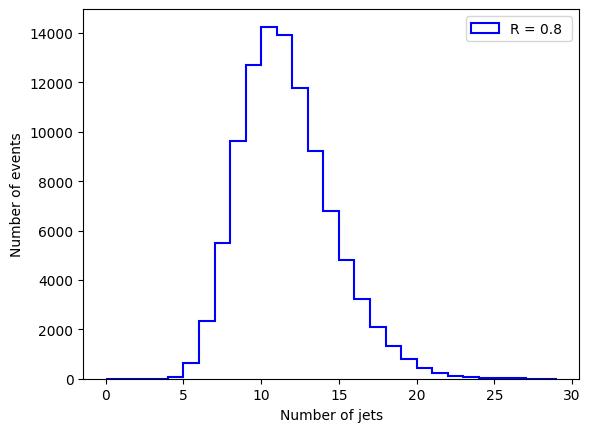

In [ ]:
n_jets = R_d[0]
plt.hist(n_jets, bins = np.arange(0, 30), label = 'R = 0.8 ', color = 'blue', histtype = 'step', linewidth = 1.5)
plt.xlabel("Number of jets")
plt.ylabel("Number of events")
plt.legend()
plt.show()